<a href="https://colab.research.google.com/github/quanndm/kltn/blob/main/notebooks/visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 3320, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 3320 (delta 137), reused 87 (delta 49), pack-reused 3117 (from 3)
Receiving objects: 100% (3320/3320), 103.26 MiB | 16.83 MiB/s, done.
Resolving deltas: 100% (2275/2275), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json
import pathlib
import re

from kltn import *
from kltn.datasets.lits import Lits, Stage2Dataset2D
from kltn.datasets.get_datasets import get_datasets_lits, convert_to_2D_dataset_v1
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage1
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results, visualize_results_stage_1, visualize_ct_slice
from kltn.utils.utils import find_best_slice, preprocessing_liver, preprocessing_tumor, predict_and_resize_mask_stage_1, predict_and_resize_mask_stage_2
from kltn.processing.preprocessing import resize_crop_to_bbox_size, uncrop_to_full_image, resize_image
from kltn.processing.postprocessing import post_trans_stage1, post_processing_stage2
from skimage.transform import resize

In [4]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
path = "/content/LITS17/"

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 url seed (http://host1.academictorrents.com/share/) failed: Host not found (authoritative)
LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
0.69% complete (down: 10094.3 kB/s up: 286.5 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 sk

In [7]:
import json

path_save_result = f"/content/gdrive/MyDrive/KLTN/bbox.json"
def load_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

liver_masks_bbox = load_json(path_save_result)

In [8]:
convert_to_2D_dataset_v1(source=config["source_folder_lits"], bbox=liver_masks_bbox, slides=3, save_dir=config["path_save_dataset_2D"]) # 3 slide of 3d and stride 2

Patient 45 processed.
Patient 76 processed.
Patient 104 processed.
Patient 22 processed.
Patient 98 processed.
Patient 0 processed.
Patient 27 processed.
Patient 38 processed.
Patient 91 processed.
Patient 39 processed.
Patient 28 processed.
Patient 32 processed.
Patient 125 processed.
Patient 83 processed.
Patient 130 processed.
Patient 75 processed.
Patient 111 processed.
Patient 124 processed.
Patient 4 processed.
Patient 108 processed.
Patient 117 processed.
Patient 61 processed.
Patient 7 processed.
Patient 90 processed.
Patient 110 processed.
Patient 82 processed.
Patient 14 processed.
Patient 101 processed.
Patient 109 processed.
Patient 65 processed.
Patient 62 processed.
Patient 106 processed.
Patient 34 processed.
Patient 126 processed.
Patient 49 processed.
Patient 52 processed.
Patient 23 processed.
Patient 70 processed.
Patient 15 processed.
Patient 24 processed.
Patient 89 processed.
Patient 36 processed.
Patient 9 processed.
Patient 92 processed.
Patient 53 processed.
Pa

In [31]:
!tar -czf 2D_dataset.tar.gz -C 2D_dataset .

Streaming output truncated to the last 5000 lines.
./patient_110_slice_113.npz
./patient_27_slice_555.npz
./patient_108_slice_211.npz
./patient_111_slice_347.npz
./patient_10_slice_311.npz
./patient_118_slice_299.npz
./patient_124_slice_389.npz
./patient_90_slice_377.npz
./patient_122_slice_137.npz
./patient_103_slice_345.npz
./patient_82_slice_329.npz
./patient_83_slice_865.npz
./patient_4_slice_267.npz
./patient_98_slice_313.npz
./patient_4_slice_147.npz
./patient_5_slice_479.npz
./patient_87_slice_875.npz
./patient_101_slice_341.npz
./patient_94_slice_223.npz
./patient_17_slice_409.npz
./patient_19_slice_397.npz
./patient_27_slice_653.npz
./patient_34_slice_063.npz
./patient_60_slice_209.npz
./patient_71_slice_081.npz
./patient_83_slice_127.npz
./patient_126_slice_393.npz
./patient_95_slice_581.npz
./patient_9_slice_211.npz
./patient_89_slice_467.npz
./patient_109_slice_331.npz
./patient_67_slice_001.npz
./patient_43_slice_043.npz
./patient_117_slice_393.npz
./patient_22_slice_203.n

In [32]:
!mv 2D_dataset.tar.gz /content/gdrive/MyDrive/KLTN/

In [ ]:
!cp /content/gdrive/MyDrive/KLTN/2D_dataset.tar.gz .

In [ ]:
!mkdir 2D_dataset
!tar -xzvf 2D_dataset.tar.gz -C 2D_dataset

## Visualize Liver

In [21]:
index_1 = 4
image_1 = Lits.load_nii(f"{path}/volume-{index_1}.nii")
mask_1 = Lits.load_nii(f"{path}/segmentation-{index_1}.nii")

best slide:  538


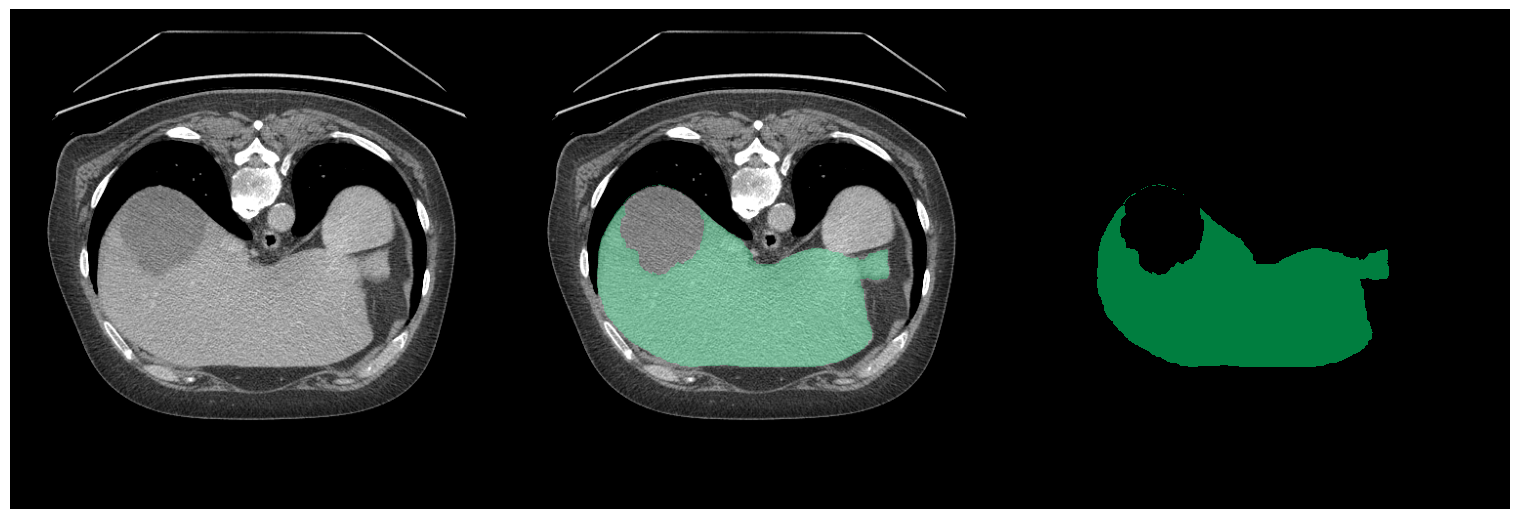

In [22]:
mask_ = (mask_1==1).astype(np.uint8)
best_slide = find_best_slice(image_1, mask_)
image_1 = np.clip(image_1, -200, 250)
print("best slide: ", best_slide)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_visible(False)
visualize_ct_slice(image_1, None, slice_index=best_slide,  ax=axes[0])
visualize_ct_slice(image_1, mask_, slice_index=best_slide, tumor=False, alpha=0.5,  ax=axes[1])
visualize_ct_slice(None, mask_, slice_index=best_slide, tumor=False, alpha=1,  ax=axes[2])

In [23]:
import glob
print(glob.glob("/content/gdrive/MyDrive/KLTN/code/weight/best_metric_*liver*.pth"))

['/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver_1.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet_liver_mcb.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSCoTNeXtUNet_liver_msa.pth']


In [24]:
weight_liver = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet_liver_mcb.pth"
model_liver = ModelFactory.get_model("unet3d_resnextcot_mcb",in_channels=1, n_classes=1, n_channels=16).to(device)
model_liver.load_state_dict(torch.load(weight_liver))

<All keys matched successfully>

In [25]:
image_liver, seg_liver = predict_and_resize_mask_stage_1(model_liver, image_1, mask_1)

In [26]:
mask_full_liver = (mask_1 > 0).astype(np.uint8)

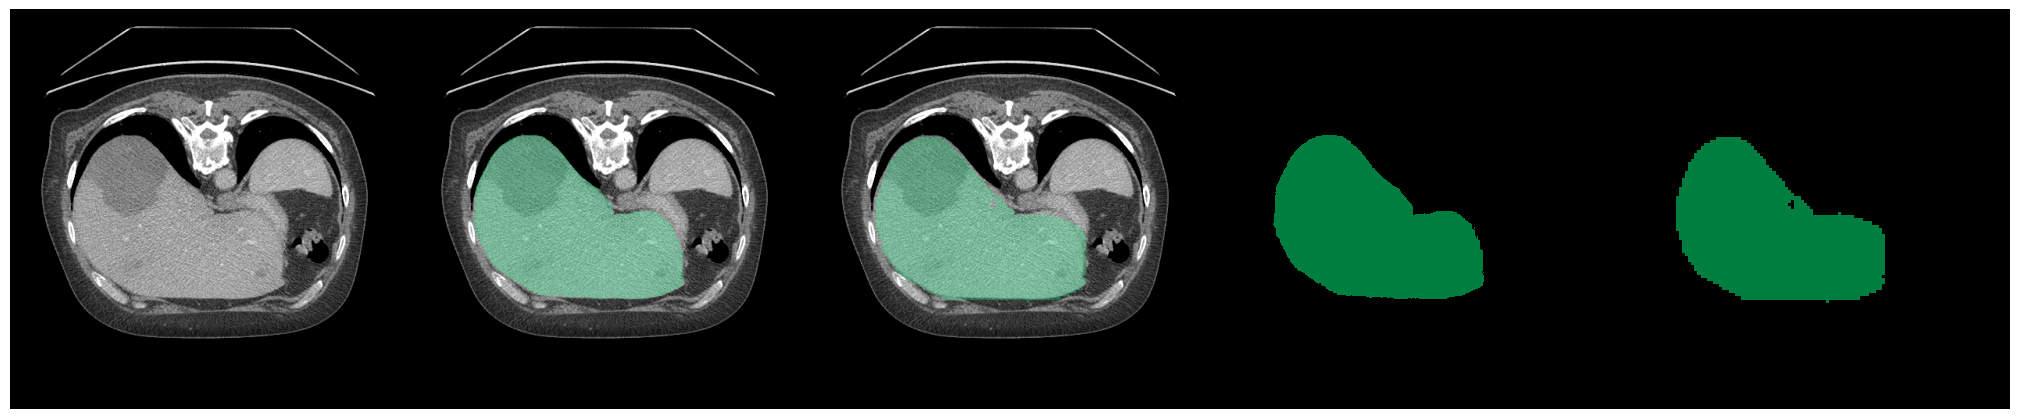

In [27]:
best_slide_pred = find_best_slice(image_liver, seg_liver)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.patch.set_visible(False)
visualize_ct_slice(image_1, None, slice_index=best_slide_pred,  ax=axes[0])
visualize_ct_slice(image_1, mask_full_liver, slice_index=best_slide_pred, tumor=False, alpha=0.5,  ax=axes[1])
visualize_ct_slice(image_1, seg_liver, slice_index=best_slide_pred, tumor=False, alpha=0.5,  ax=axes[2])
visualize_ct_slice(None, mask_full_liver, slice_index=best_slide_pred, tumor=False, alpha=1,  ax=axes[3])
visualize_ct_slice(None, seg_liver, slice_index=best_slide_pred, tumor=False, alpha=1,  ax=axes[4])

In [28]:
index_2 = 1
image_2 = Lits.load_nii(f"{path}/volume-{index_2}.nii")
mask_2 = Lits.load_nii(f"{path}/segmentation-{index_2}.nii")

image_2 = np.clip(image_2, -200, 250)

In [29]:
image_liver_2, seg_liver_2 = predict_and_resize_mask_stage_1(model_liver, image_2, mask_2)
mask_full_liver_2 = (mask_2 > 0).astype(np.uint8)

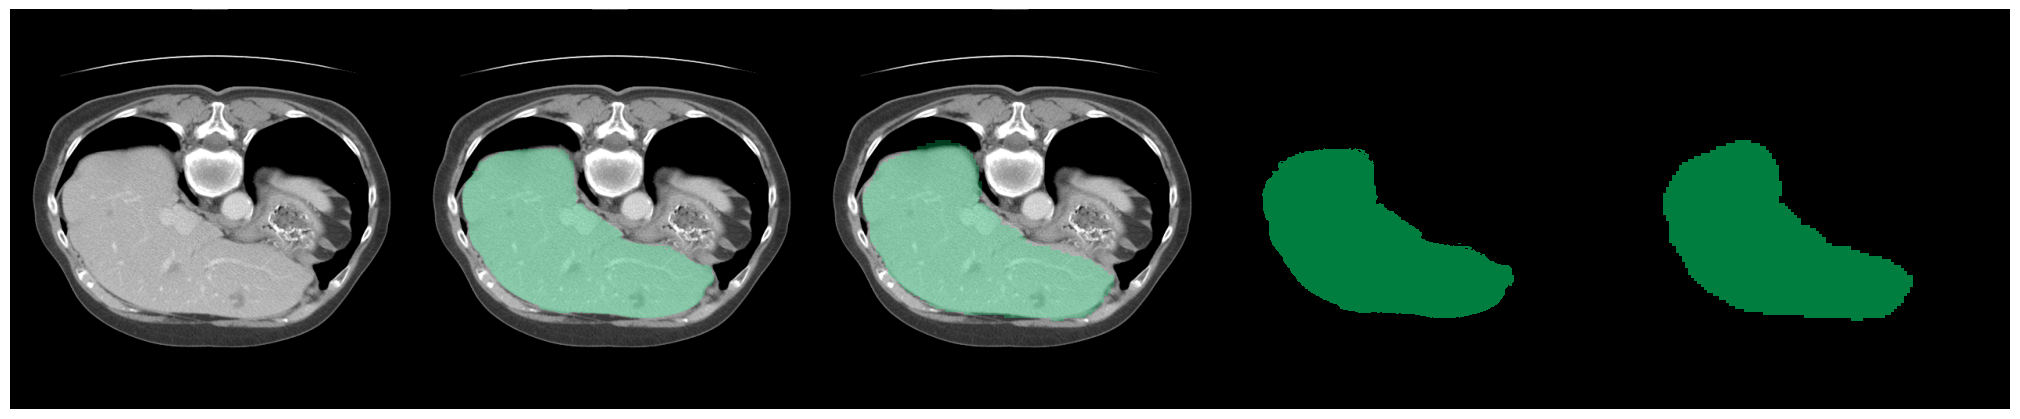

In [30]:
best_slide_pred_2 = find_best_slice(image_liver_2, seg_liver_2)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.patch.set_visible(False)
visualize_ct_slice(image_2, None, slice_index=best_slide_pred_2,  ax=axes[0])
visualize_ct_slice(image_2, mask_full_liver_2, slice_index=best_slide_pred_2, tumor=False, alpha=0.5,  ax=axes[1])
visualize_ct_slice(image_2, seg_liver_2, slice_index=best_slide_pred_2, tumor=False, alpha=0.5,  ax=axes[2])
visualize_ct_slice(None, mask_full_liver_2, slice_index=best_slide_pred_2, tumor=False, alpha=1,  ax=axes[3])
visualize_ct_slice(None, seg_liver_2, slice_index=best_slide_pred_2, tumor=False, alpha=1,  ax=axes[4])

## Visualize Tumor

In [12]:
base_folder = pathlib.Path(config["path_save_dataset_2D"]).resolve()


# Get the list of volume the files in the folder
patient_files = list(base_folder.glob('*patient*.npz'))
str_paths = [str(p) for p in patient_files]
patient_1 = 4
pattern_1 = re.compile(rf"patient_{patient_1}(?=_|\D)")
filtered_1 = [p for p in str_paths if pattern_1.search(p)]

patient_2 = 16
pattern_2 = re.compile(rf"patient_{patient_2}(?=_|\D)")
filtered_2 = [p for p in str_paths if pattern_2.search(p)]

In [13]:
image_1 = Lits.load_nii(f"{path}/volume-4.nii")
image_1 = np.clip(image_1, -200, 250)
mask_1 = Lits.load_nii(f"{path}/segmentation-4.nii")

image_2 = Lits.load_nii(f"{path}/volume-16.nii")
image_2 = np.clip(image_2, -200, 250)
mask_2 = Lits.load_nii(f"{path}/segmentation-16.nii")

In [14]:
best_slide_1 = find_best_slice(image_1, mask_1)
best_slide_2 = find_best_slice(image_2, mask_2)
print(best_slide_1, best_slide_2)

508 409


In [15]:
patient_1_path = "/content/2D_dataset/patient_4_slice_507.npz" # 506, 507, 508
patient_2_path = "/content/2D_dataset/patient_16_slice_409.npz" # 408, 409, 410

In [16]:
weight_tumor = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet2D_tumor_mcb.pth"
model_tumor = ModelFactory.get_model("unet2d_resnextcot_mcb",in_channels=3, n_classes=1, n_channels=32).to(device)
model_tumor.load_state_dict(torch.load(weight_tumor))

<All keys matched successfully>

In [17]:
full_tumor_mask_pred_1 = predict_and_resize_mask_stage_2(model_tumor, patient_1_path, image_1[best_slide_1].shape)
full_tumor_mask_pred_2 = predict_and_resize_mask_stage_2(model_tumor, patient_2_path, image_2[best_slide_2].shape)

In [18]:
mask_full_tumor_1= (mask_1 == 2).astype(np.uint8)
mask_full_tumor_2= (mask_2 == 2).astype(np.uint8)

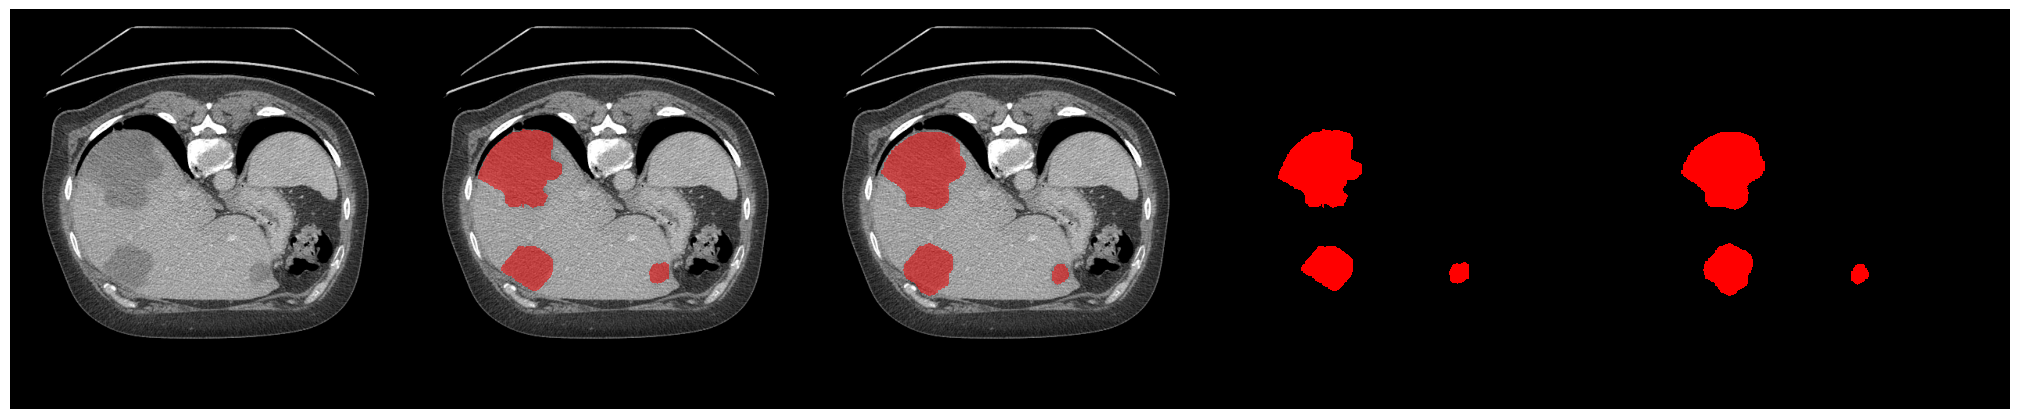

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.patch.set_visible(False)

visualize_ct_slice(image_1, None, slice_index=best_slide_1,  ax=axes[0])
visualize_ct_slice(image_1, mask_full_tumor_1, slice_index=best_slide_1, tumor=True,alpha=0.5,  ax=axes[1])
visualize_ct_slice(np.expand_dims(image_1[best_slide_1], axis=0), full_tumor_mask_pred_1, tumor=True, alpha=0.5,  ax=axes[2])
visualize_ct_slice(None, mask_full_tumor_1, slice_index=best_slide_1, tumor=True, alpha=1,  ax=axes[3])
visualize_ct_slice(None, full_tumor_mask_pred_1, slice_index=0, tumor=True, alpha=1,  ax=axes[4])

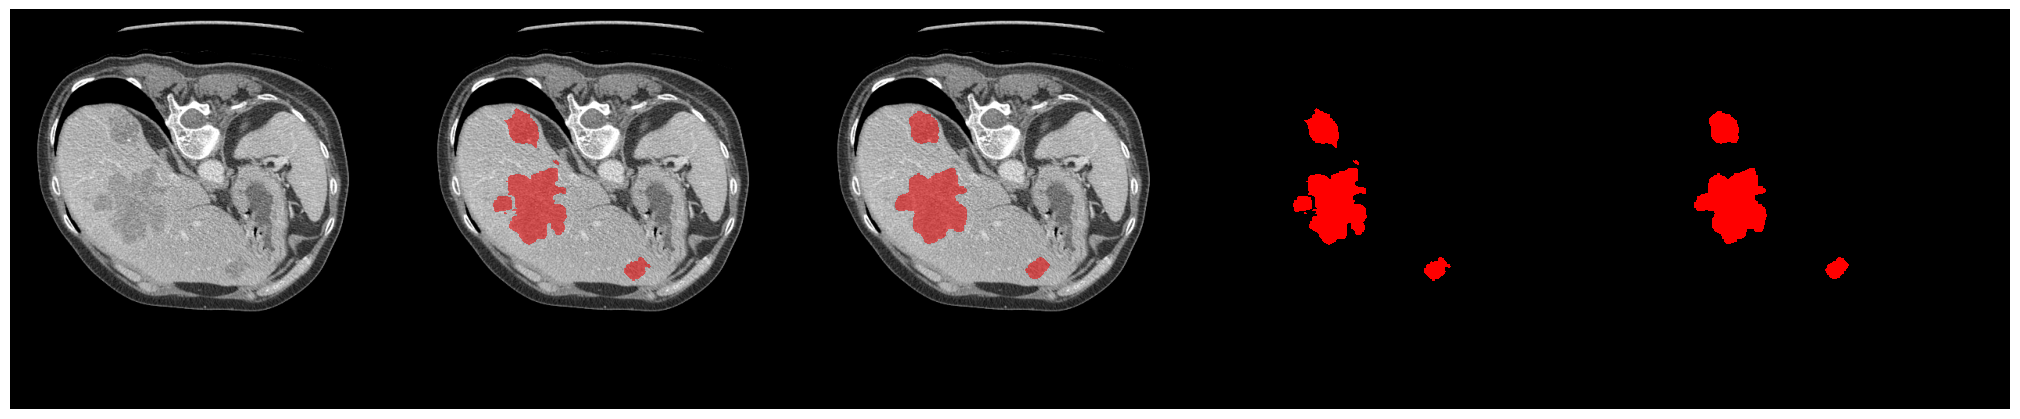

In [20]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.patch.set_visible(False)

visualize_ct_slice(image_2, None, slice_index=best_slide_2,  ax=axes[0])
visualize_ct_slice(image_2, mask_full_tumor_2, slice_index=best_slide_2, tumor=True,alpha=0.5,  ax=axes[1])
visualize_ct_slice(np.expand_dims(image_2[best_slide_2], axis=0), full_tumor_mask_pred_2, tumor=True, alpha=0.5,  ax=axes[2])
visualize_ct_slice(None, mask_full_tumor_2, slice_index=best_slide_2, tumor=True, alpha=1,  ax=axes[3])
visualize_ct_slice(None, full_tumor_mask_pred_2, slice_index=0, tumor=True, alpha=1,  ax=axes[4])